In [355]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm
from collections import Counter, deque
tqdm.pandas()

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

plt.rcParams['figure.figsize'] = 12, 7

<ipython-input-355-9cade408cd8e>:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Data Analysis

In [2]:
df_ch = pd.read_csv('lentahack/20210518_checks.csv')
print(df_ch.shape)
df_ch.head()

(21479259, 12)


,client_id,day,shop_id,check_id,time,sku,promo_id,check_pos,num_sales,supplier_price,selling_price,region_name
0,d9da50b77962ad6401d0527db5b65b04,20191230,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b17c870027bb4a22e3aedb971bc00def,b3deb0286313f0b888c0eac49580cc23,1,5.0,133.40,249.45,152f1b77a32508570e2745daf9ce7aec
1,d9da50b77962ad6401d0527db5b65b04,20191230,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b9ef00e971d0fb459a765708efba70c0,680a96609351230ed00e1d1090371cbc,2,1.0,96.77,118.99,152f1b77a32508570e2745daf9ce7aec
2,d9da50b77962ad6401d0527db5b65b04,20191230,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b75147feae4cf8ec07fb5f2cef855def,7215ee9c7d9dc229d2921a40e899ec5f,5,2.0,2.34,7.58,152f1b77a32508570e2745daf9ce7aec
3,d9da50b77962ad6401d0527db5b65b04,20191230,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b25e0d42165d246d23cbf4d3efcdf583,7215ee9c7d9dc229d2921a40e899ec5f,4,1.0,23.59,39.99,152f1b77a32508570e2745daf9ce7aec
4,d9da50b77962ad6401d0527db5b65b04,20191230,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,a537d2eef30d47f9b11d655421ca93fb,05c93d4fa9bdbe70b5d2204ce9548ca9,3,1.0,24.02,39.99,152f1b77a32508570e2745daf9ce7aec


In [624]:
df_checks = df_ch[['sku', 'check_id']].rename(columns={'sku': 'sku_root'}).merge(
    df_ch[['sku', 'check_id', 'selling_price']], on='check_id')
df_checks = df_checks.merge(df_hi, on='sku')

In [625]:
df_checks.shape

(494140073, 8)

In [628]:
df_checks

,sku_root,check_id,sku,selling_price,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4
0,b17c870027bb4a22e3aedb971bc00def,c0b3f9c2215f924e27a6039617999c60,b17c870027bb4a22e3aedb971bc00def,249.45,44a7b825383402ed937a15fb8a5bb12a,ea5d2f1c4608232e07d3aa3d998e5135,d994e3728ba5e28defb88a3289cd7ee8,b84633d3396f28a04889d2e5a41c7b0b
1,b9ef00e971d0fb459a765708efba70c0,c0b3f9c2215f924e27a6039617999c60,b17c870027bb4a22e3aedb971bc00def,249.45,44a7b825383402ed937a15fb8a5bb12a,ea5d2f1c4608232e07d3aa3d998e5135,d994e3728ba5e28defb88a3289cd7ee8,b84633d3396f28a04889d2e5a41c7b0b
2,b75147feae4cf8ec07fb5f2cef855def,c0b3f9c2215f924e27a6039617999c60,b17c870027bb4a22e3aedb971bc00def,249.45,44a7b825383402ed937a15fb8a5bb12a,ea5d2f1c4608232e07d3aa3d998e5135,d994e3728ba5e28defb88a3289cd7ee8,b84633d3396f28a04889d2e5a41c7b0b
3,b25e0d42165d246d23cbf4d3efcdf583,c0b3f9c2215f924e27a6039617999c60,b17c870027bb4a22e3aedb971bc00def,249.45,44a7b825383402ed937a15fb8a5bb12a,ea5d2f1c4608232e07d3aa3d998e5135,d994e3728ba5e28defb88a3289cd7ee8,b84633d3396f28a04889d2e5a41c7b0b
4,a537d2eef30d47f9b11d655421ca93fb,c0b3f9c2215f924e27a6039617999c60,b17c870027bb4a22e3aedb971bc00def,249.45,44a7b825383402ed937a15fb8a5bb12a,ea5d2f1c4608232e07d3aa3d998e5135,d994e3728ba5e28defb88a3289cd7ee8,b84633d3396f28a04889d2e5a41c7b0b
...,...,...,...,...,...,...,...,...
494140068,65bb4fb91db44d08e351ea9b9a3e3798,a944250c1f48940eec80c883f8646fb9,e73a4c7a875fced77d5a265b7aa954bf,142.28,44a7b825383402ed937a15fb8a5bb12a,ea5d2f1c4608232e07d3aa3d998e5135,012d9fe15b2493f21902cd55603382ec,4af1f45499806325ccd10e1cd2f85b57
494140069,76ba1abdab212f78182cedb5e2bd0dec,a944250c1f48940eec80c883f8646fb9,e73a4c7a875fced77d5a265b7aa954bf,142.28,44a7b825383402ed937a15fb8a5bb12a,ea5d2f1c4608232e07d3aa3d998e5135,012d9fe15b2493f21902cd55603382ec,4af1f45499806325ccd10e1cd2f85b57
494140070,5bb156d705217720a8d121af2022056e,a944250c1f48940eec80c883f8646fb9,e73a4c7a875fced77d5a265b7aa954bf,142.28,44a7b825383402ed937a15fb8a5bb12a,ea5d2f1c4608232e07d3aa3d998e5135,012d9fe15b2493f21902cd55603382ec,4af1f45499806325ccd10e1cd2f85b57
494140071,614017c9ba0d60c8437da1d4fb20fa8c,a944250c1f48940eec80c883f8646fb9,e73a4c7a875fced77d5a265b7aa954bf,142.28,44a7b825383402ed937a15fb8a5bb12a,ea5d2f1c4608232e07d3aa3d998e5135,012d9fe15b2493f21902cd55603382ec,4af1f45499806325ccd10e1cd2f85b57


In [630]:
df_checks.shape

(494140073, 4)

In [631]:
df_checks = df_ch[['sku', 'check_id']].rename(columns={'sku': 'sku_root'}).merge(
    df_ch[['sku', 'check_id', 'selling_price']], on='check_id')
df_checks = df_checks.merge(df_hi, on='sku')

class MostCommon:
    def __init__(self, count):
        self.count = count
    def __call__(self, arr):
        arr = Counter(arr).most_common(self.count)
        return {k: v for k, v in arr}

df_checks.groupby('sku_root').agg({'hierarchy_level1': MostCommon(1)})

SpecificationError: Column(s) ['hierarchy_level1'] do not exist

In [88]:
df_ch['day'] = pd.to_datetime(df_ch.day, format='%Y%m%d')

In [ ]:
df_ch['is_promo'] = (df_ch.promo_id != '7215ee9c7d9dc229d2921a40e899ec5f').astype(int)
df_ch.is_promo.value_counts()

In [21]:
df_ch.region_name.value_counts()

152f1b77a32508570e2745daf9ce7aec    12353882
7e35e74e610188414ad24235dd787c78     9125377
Name: region_name, dtype: int64

In [146]:
df_ch.shop_id.nunique()

111

In [145]:
df_ch.sku.nunique()

80406

In [3]:
df_hi = pd.read_csv('lentahack/20210518_hierarchy.csv')
print(df_hi.shape)
df_hi.head()

(80406, 5)


,sku,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4
0,29285fb39582e5a63c14026198c6ad51,44a7b825383402ed937a15fb8a5bb12a,9a1158154dfa42caddbd0694a4e9bdc8,f50c7035e532c49a0f6993d988e2e843,e9f41ed96e63ca1be6aea099625afe6f
1,f31d0af494b191ef2bc8395db9c8366f,44a7b825383402ed937a15fb8a5bb12a,ad61ab143223efbc24c7d2583be69251,84e8ce7870f0eecd843366582bb95a28,b7fa186535a75c869bfaece622c72689
2,49edad6669ba09dffbf278b76c53cd9d,cc9284597026dcc021735c0970ca0c93,1c383cd30b7c298ab50293adfecb7b18,2a3d6d6cc4b5e77238c1fc1bb6cdd681,7e0e0c1fe174b2d2efbf5ae0e2bc3ee9
3,c5c632eb0f93a233ef6db2620a464ea0,44a7b825383402ed937a15fb8a5bb12a,d82c8d1619ad8176d665453cfb2e55f0,b27d5296bede63b1493a5d321d4e8092,ec2acf8ebfdb679d5fc87caadd98fb58
4,9d0c7880f16c7748e1e992b28655c67f,cc9284597026dcc021735c0970ca0c93,6ea9ab1baa0efb9e19094440c317e21b,379a7ba015d8bf1c70b8add2c287c6fa,5aec2478fac4d1ee912c794c343d036c


In [17]:
df_hi.hierarchy_level1.value_counts()

44a7b825383402ed937a15fb8a5bb12a    43439
cc9284597026dcc021735c0970ca0c93    36967
Name: hierarchy_level1, dtype: int64

In [20]:
df_hi.hierarchy_level2.nunique(), df_hi.hierarchy_level3.nunique(), df_hi.hierarchy_level4.nunique()

(65, 412, 2119)

In [4]:
df_up = pd.read_csv('lentahack/20210518_uplift.csv')
print(df_up.shape)
df_up.head()

(740, 2)


,Offer_ID,UpLift
0,241,1.743427
1,70,16.870948
2,342,15.185624
3,B33,0.921722
4,244,4.862729


In [5]:
df_of = pd.read_csv('lentahack/20210521_offers.csv')
print(df_of.shape)
df_of.head()

(9776, 6)


,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group
0,Facades,F26,71c770923102af052f64c6036c9dd590,20200213,20200219,train
1,Facades,F2,e87788b585ead792a4d40f7de18f2f76,20200102,20200108,train
2,Facades,F9,5ae92b5e465d630285677e80b43fe5f7,20200116,20200122,train
3,Facades,F45,0790b472112a765339f0e5c3f66816ee,20200319,20200325,train
4,Facades,F191,e87788b585ead792a4d40f7de18f2f76,20201112,20201118,test


In [90]:
df_of['start_date'] = pd.to_datetime(df_of.start_date, format='%Y%m%d')
df_of['end_date'] = pd.to_datetime(df_of.end_date, format='%Y%m%d')

In [96]:
df_of['duration'] = df_of.apply(lambda row: row.end_date - row.start_date, axis=1)
df_of['duration'] = df_of.duration.apply(lambda x: x.days + x.seconds / 3600 / 24)

In [14]:
df_of[['Offer_ID', 'sku']].drop_duplicates().shape

(9776, 2)

In [11]:
df_of.sku.nunique()

4200

In [10]:
df_of.sku.value_counts()[:5]

5abc0869d756fa1c6831651776138baa    26
33306ccd877e73c388652739869d3dc7    22
7a8675a8f6988ebcbefd062fabaccc85    21
c8ac520562ba934dd67cbf0f060c4252    18
787762f7d829ce318599bf015baba175    17
Name: sku, dtype: int64

In [7]:
df_of.Promo_type.value_counts()

Seasonal      3455
Biweekly      2998
Facades       2513
Billboards     810
Name: Promo_type, dtype: int64

In [16]:
df_of.train_test_group.value_counts()

train    7716
test     2060
Name: train_test_group, dtype: int64

In [6]:
df_sa = pd.read_csv('lentahack/20210521_sample_submission.csv')
print(df_sa.shape)
df_sa.head()

(149, 2)


,Offer_ID,UpLift
0,386,0
1,182,0
2,173,0
3,375,0
4,379,0


In [245]:
df_ofup = df_of.merge(df_up, on='Offer_ID')
#df_ofup.groupby('Offer_ID').agg({'sku': 'count'})
#dummies = pd.get_dummies(df_ofup.sku)
#df_ofup = pd.concat([df_ofup, dummies], axis=1)
df_ofup.shape

(7716, 8)

In [130]:
df_ofup.sku.value_counts()[df_ofup.sku.value_counts() >= 3].index

Index(['33306ccd877e73c388652739869d3dc7', '5abc0869d756fa1c6831651776138baa',
       '7a8675a8f6988ebcbefd062fabaccc85', '787762f7d829ce318599bf015baba175',
       'c8ac520562ba934dd67cbf0f060c4252', '911d7361089a37c2a6488a548b4f06a8',
       'ce414dc56ab84ef9ef6c00da08747cad', '290765c709b1efb039791a793e5bac01',
       '8ce96f975fabfd21c938034b4e33ef38', '77f07f6168e3f1fdf22caed73164eb49',
       ...
       'eb86c8433b0998695da6beba131f7311', 'ebae2dec1bcb8b456f983d0747b8db2d',
       'f2ba68b41937ff806cb677999682458a', '98d6b2963231045201b56d96ece261bf',
       'f9fae7ac76c13b2e49d1264003d0a87d', '4d2a56420489953ed5b76a38c7bccd28',
       '00104b38b0b48f14e6b94c294a91356b', '7eb3077272fd22f863050961b096195e',
       '1526b93698c8de388d8ce349631af2bb', '296bfe0ebf5b24ea027856dc240c8985'],
      dtype='object', length=969)

/anaconda/envs/py38_default/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


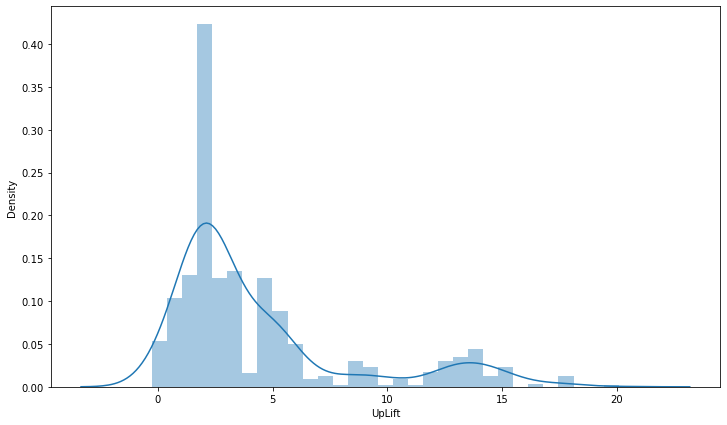

In [131]:
df_sku = df_ofup[df_ofup.sku.isin(df_ofup.sku.value_counts()[df_ofup.sku.value_counts() >= 3].index.to_list())][['sku', 'UpLift']].groupby('sku').mean()
df_sku = df_sku.sort_values('UpLift', ascending=False)
sns.distplot(df_sku.UpLift);

/anaconda/envs/py38_default/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


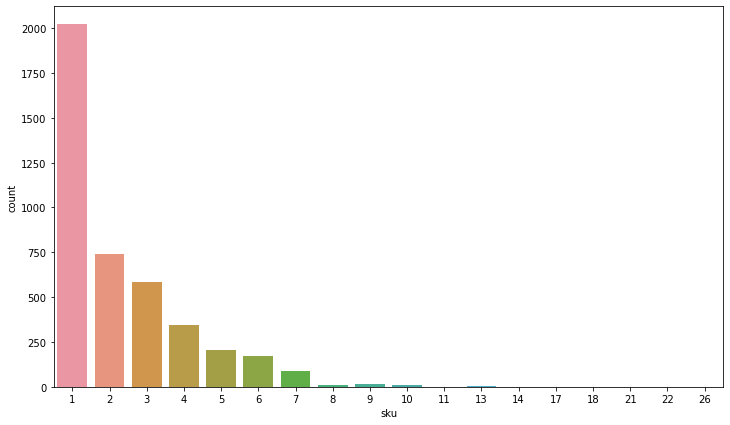

In [158]:
sns.countplot(df_of.sku.value_counts());

In [140]:
df_sku = df_ofup.groupby(['Offer_ID', 'UpLift', 'Promo_type']).agg({'sku': list}).reset_index()
df_sku['sku'] = df_sku.sku.apply(lambda x: tuple(sorted(x)))
df_sku = df_sku.groupby(['sku', 'Promo_type']).agg({'UpLift': 'mean', 'Offer_ID': 'count'}).reset_index()
#df_sku.sort_values('UpLift', ascending=False)

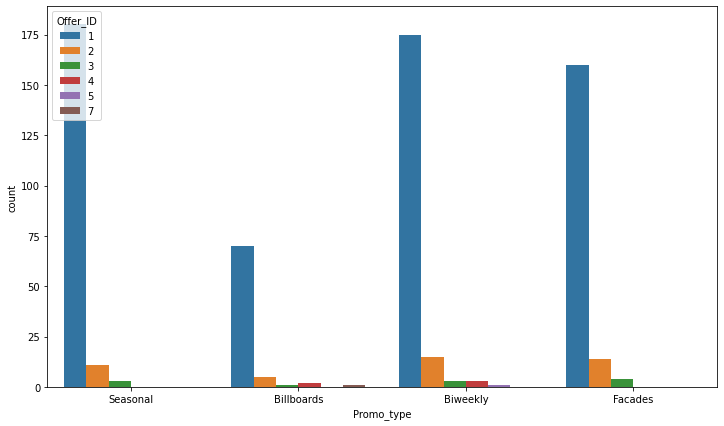

In [142]:
sns.countplot(
    data=df_sku,
    x='Promo_type',
    hue='Offer_ID'
);

In [143]:
df_ofup.groupby('Promo_type').mean()

,duration,UpLift
Promo_type,,
Billboards,10.997080,3.620010
Biweekly,13.472682,5.561029
Facades,6.000000,2.630749
Seasonal,17.733487,3.708450


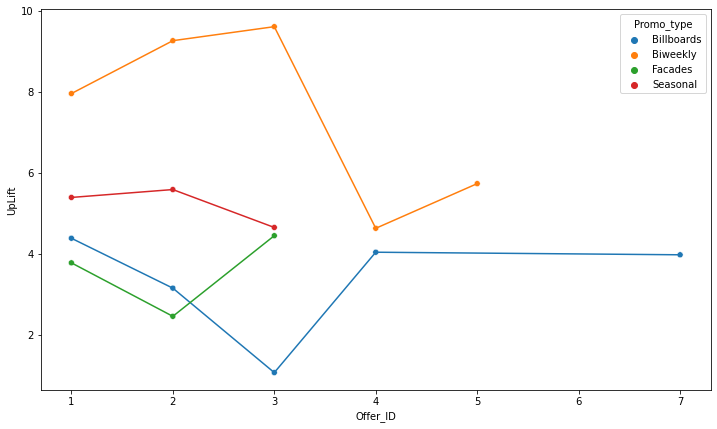

In [144]:
df_plot = df_sku.groupby(['Offer_ID', 'Promo_type']).mean().reset_index()

sns.scatterplot(
    data=df_plot,
    x='Offer_ID',
    y='UpLift',
    hue='Promo_type'
);

sns.lineplot(
    data=df_plot,
    x='Offer_ID',
    y='UpLift',
    hue='Promo_type',
    legend=False
);

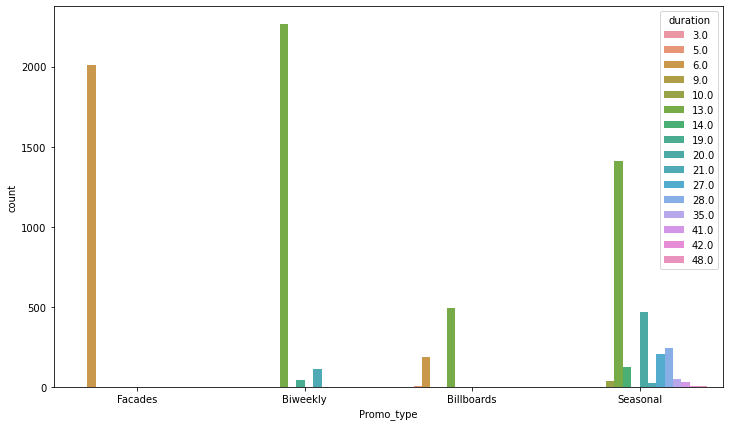

In [132]:
sns.countplot(
    data=df_ofup, 
    x='Promo_type',
    hue='duration'
);

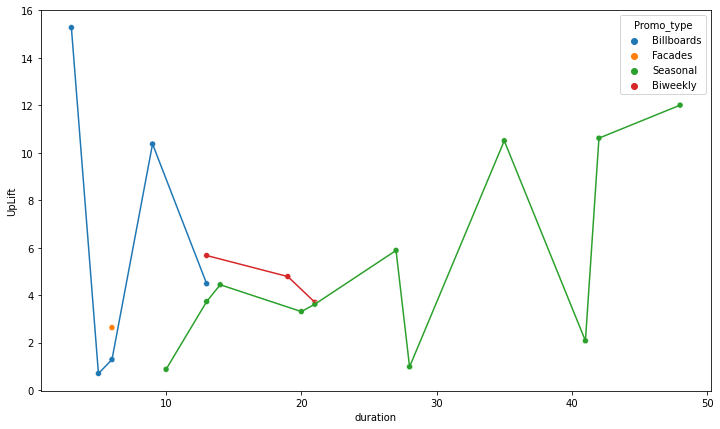

In [118]:
df_plot = df_ofup.groupby(['duration', 'Promo_type']).mean().reset_index()

sns.scatterplot(
    data=df_plot,
    x='duration',
    y='UpLift',
    hue='Promo_type'
);

sns.lineplot(
    data=df_plot,
    x='duration',
    y='UpLift',
    hue='Promo_type',
    legend=False
);

## Data Preprocessing

In [153]:
df_of.start_date.min()

Timestamp('2019-09-24 00:00:00')

In [159]:
df_ch['weekday'] = df_ch.day.progress_apply(lambda x: x.strftime('%A'))

100%|██████████| 21479259/21479259 [02:42<00:00, 132434.52it/s]


In [167]:
df_ch['time'] = pd.to_timedelta(df_ch.time)

In [182]:
def part_of_day(time):
    out = None
    if time >= dt.timedelta(hours=0) and time <= dt.timedelta(hours=6): out = 'night'
    elif time >= dt.timedelta(hours=6) and time <= dt.timedelta(hours=12): out = 'morning'
    elif time >= dt.timedelta(hours=12) and time <= dt.timedelta(hours=18): out = 'day'
    elif time >= dt.timedelta(hours=18) and time <= dt.timedelta(hours=24): out = 'evening'
        
    return out

def part_of_day(time):
    out = None
    hours = time.days * 24 + time.seconds/3600
    if hours >= 0 and hours < 6: out = 'night'
    elif hours >= 6 and hours < 12: out = 'morning'
    elif hours >= 12 and hours < 18: out = 'day'
    elif hours >= 18 and hours <= 24: out = 'evening'
        
    return out

df_ch['part_of_day'] = df_ch.time.progress_apply(part_of_day)

100%|██████████| 21479259/21479259 [03:22<00:00, 106121.77it/s]


In [459]:
df_up.UpLift.median()

3.03963275955

In [183]:
df_ch.part_of_day.value_counts()

day        10321187
evening    7851278 
morning    2878310 
night      428484  
Name: part_of_day, dtype: int64

In [479]:
df_ch.merge(df_ofup[df_ofup.train_test_group == 'test'], on='sku')

,client_id,day,shop_id,check_id,time,sku,promo_id,check_pos,num_sales,supplier_price,selling_price,region_name,weekday,part_of_day,is_promo,Promo_type,Offer_ID,start_date,end_date,train_test_group,duration,UpLift


In [959]:
df_checks = df_ch[df_ch.sku.isin(df_agg.sku.unique())][['sku', 'check_id']].rename(columns={'sku': 'sku_root'}).merge(
    df_ch[['sku', 'check_id', 'selling_price', 'num_sales']], on='check_id')

class MostCommon:
    def __init__(self, count):
        self.count = count
    def __call__(self, arr):
        arr = Counter(arr).most_common(self.count)
        return {k: v for k, v in arr}

aggdict = {
    'selling_price': 'sum',
    'num_sales': 'sum',
}
df_counts = df_checks.groupby(['sku_root', 'check_id']).agg(aggdict).reset_index().reset_index()
aggdict = {
    'selling_price': ['min', 'mean', 'max'],
    'num_sales': ['min', 'mean', 'max'],
}
df_counts = df_counts.groupby('sku_root').agg(aggdict).rename(columns={'sku_root': 'sku'})
df_counts

selling_price                        \
                                           min         mean      max   
sku_root                                                               
00033dd12618c86f7451b1e18af8bb60  229.00        1977.180000  6489.0    
00104b38b0b48f14e6b94c294a91356b  12.99         3074.967414  40701.0   
00218695e83d28a79151ef327e51200c  159.00        3419.949153  35096.0   
00432d021eca6059fee2ed69a732c2b2  13.00         3375.811940  29077.0   
00581113943ffd4c16964dd1b545044f  86.00         2632.295285  16530.0   
...                                  ...                ...      ...   
ff6806b34403247f7d2429b9dac2eff3  70.00         3026.395711  26271.0   
ff9bf520af5f68d957aa193977ec8b85  190.00        3449.457627  16708.0   
ffb361905f5828922df2edcc7d50d3b8  799.00        4576.155440  17584.0   
ffd28420812333369041b2434a483ee8  3.00          2518.402124  34748.0   
ffea752b2c9ed2fd6c6777532daccd61  16.00         3061.803704  14433.0   

                                 num_sales                       
                                       min       mean       max  
sku_root                                                         
00033dd12618c86f7451b1e18af8bb60  1.0       19.665720  120.0000  
00104b38b0b48f14e6b94c294a91356b  1.0       35.710734  295.0020  
00218695e83d28a79151ef327e51200c  1.0       35.150093  314.3080  
00432d021eca6059fee2ed69a732c2b2  1.0       37.841898  277.6525  
00581113943ffd4c16964dd1b545044f  1.0       34.118983  230.8440  
...                               ...             ...       ...  
ff6806b34403247f7d2429b9dac2eff3  1.0       35.238288  232.2280  
ff9bf520af5f68d957aa193977ec8b85  3.0       38.316576  157.5880  
ffb361905f5828922df2edcc7d50d3b8  1.0       32.773430  159.0000  
ffd28420812333369041b2434a483ee8  1.0       31.363342  431.3600  
ffea752b2c9ed2fd6c6777532daccd61  2.0       37.764344  197.0000  

[3197 rows x 6 columns]

In [1095]:
def process_dataset(df_ofup, df_ch, df_of, test=False):
    delta = {
        'low': dt.timedelta(days=180),
        'up': dt.timedelta(days=90)
    }

    if test:
        df_ofup = df_of[df_of.train_test_group == 'test']
    df = df_ch.merge(df_ofup, on='sku')
    df = df[(df.start_date - delta['low'] <= df.day) & (df.end_date - delta['up'] >= df.day)]
    
    df['is_promo'] = (df.promo_id != '7215ee9c7d9dc229d2921a40e899ec5f').astype(int)
    df['supplier_price_unit'] = df.supplier_price / df.num_sales
    df['selling_price_unit'] = df.selling_price / df.num_sales
        
    def list2col_share(arr):
        values = dict(Counter(arr))
        sum_values = sum(values.values())
        values = {k: v / sum_values for k, v in values.items()}

        return values
    
    def list2col_count(arr):
        values = dict(Counter(arr))
        sum_values = sum(values.values())
        values = {k: v / sum_values for k, v in values.items()}

        return values

    aggdict = {
        'check_pos': ['min', 'mean', 'max'],
        'num_sales': ['mean', 'max'],
        'supplier_price': 'sum',
        'selling_price': 'sum',
        'supplier_price_unit': ['min', 'mean', 'max'],
        'selling_price_unit': ['min', 'mean', 'max'],
        'is_promo': ['mean', 'sum', 'std'],
        'shop_id': [list2col_share, list2col_count],
        'weekday': [list2col_share, list2col_count],
        'part_of_day': [list2col_share, list2col_count],
        'region_name': [list2col_share, list2col_count],
    }

    group_cols = ['sku', 'Offer_ID', 'Promo_type', 'start_date', 'end_date', 'train_test_group', 'duration']
    if not test:
        group_cols.append('UpLift')
    df_agg = df.groupby(group_cols).agg(aggdict).reset_index()
    
    df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.columns = [col if col[-1] != '_' else col[:-1] for col in df_agg.columns]

    df_checks = df_ch.merge(df_ofup, on='sku')
    df_checks = df_checks[(df_checks.start_date - delta['low'] <= df_checks.day) & (df_checks.end_date - delta['up'] >= df_checks.day)]
    #df_checks = df_ch[df_ch.sku.isin(df_agg.sku.unique())][['sku', 'check_id']].rename(columns={'sku': 'sku_root'}).merge(
    #    df_ch[['sku', 'check_id', 'selling_price', 'num_sales']], on='check_id')
    df_checks = df_checks[['sku', 'check_id', 'start_date', 'end_date']].rename(columns={'sku': 'sku_root'}).merge(
        df_ch[['sku', 'check_id', 'selling_price', 'num_sales', 'day']], on='check_id')
    df_checks = df_checks[(df_checks.start_date - delta['low'] <= df_checks.day) & (df_checks.end_date - delta['up'] >= df_checks.day)]
    df_checks = df_checks[['sku_root', 'sku', 'check_id', 'selling_price', 'num_sales']].drop_duplicates()
    
    aggdict = {
        'selling_price': 'sum',
        'num_sales': 'sum',
    }
    df_counts = df_checks.groupby(['sku_root', 'check_id']).agg(aggdict).reset_index()
    df_counts = df_counts.rename(columns={'selling_price': 'check_selling_price', 'num_sales': 'check_num_sales'})
    aggdict = {
        'check_selling_price': ['min', 'mean', 'max', 'std'],
        'check_num_sales': ['min', 'mean', 'max', 'std'],
    }
    df_counts = df_counts.groupby('sku_root').agg(aggdict).reset_index().rename(columns={'sku_root': 'sku'})
    df_counts.columns = ['_'.join(col).strip()  if col != 'sku' else 'sku' for col in df_counts.columns.values]
    df_counts.columns = [col if col[-1] != '_' else col[:-1] for col in df_counts.columns]
    
    df_checks = df_checks.merge(df_hi, on='sku')
    df_checks['hierarchy_level1'] = df_checks.hierarchy_level1 + '_purch1'
    df_checks['hierarchy_level2'] = df_checks.hierarchy_level2 + '_purch2'

    class MostCommon:
        def __init__(self, count):
            self.count = count
        def __call__(self, arr):
            arr = Counter(arr).most_common(self.count)
            return {k: v for k, v in arr}

    aggdict = {
        'hierarchy_level1': MostCommon(1),
        'hierarchy_level2': MostCommon(5),
    }
    df_checks = df_checks.groupby('sku_root').agg(aggdict).reset_index().rename(columns={'sku_root': 'sku'})
    df_agg = df_agg.merge(df_checks, on='sku', how='left')
    df_agg = df_agg.merge(df_counts, on='sku', how='left')
    
    df = df_agg.copy()
    
    shop_id = set([col for cols in df_agg.shop_id_list2col_share.apply(lambda x: list(x.keys())) for col in cols])

    for row in tqdm(df.itertuples(), total=len(df)):
        shop_id_list2col_share = row.shop_id_list2col_share
        shop_id_list2col_count = row.shop_id_list2col_count
        for col in shop_id:
            if col in shop_id_list2col_share:
                df.at[row.Index, col + '_share'] = shop_id_list2col_share[col]
                df.at[row.Index, col + '_count'] = shop_id_list2col_count[col]
    
    weekday = set([col for cols in df_agg.weekday_list2col_share.apply(lambda x: list(x.keys())) for col in cols])

    for row in tqdm(df.itertuples(), total=len(df)):
        weekday_list2col_share = row.weekday_list2col_share
        weekday_list2col_count = row.weekday_list2col_count
        for col in weekday:
            if col in weekday_list2col_share:
                df.at[row.Index, col + '_share'] = weekday_list2col_share[col]
                df.at[row.Index, col + '_count'] = weekday_list2col_count[col]
                
    part_of_day = set([col for cols in df_agg.part_of_day_list2col_share.apply(lambda x: list(x.keys())) for col in cols])

    for row in tqdm(df.itertuples(), total=len(df)):
        part_of_day_list2col_share = row.part_of_day_list2col_share
        part_of_day_list2col_count = row.part_of_day_list2col_count
        for col in part_of_day:
            if col in part_of_day_list2col_share:
                df.at[row.Index, col + '_share'] = part_of_day_list2col_share[col]
                df.at[row.Index, col + '_count'] = part_of_day_list2col_count[col]
                
    region_name = set([col for cols in df_agg.region_name_list2col_share.apply(lambda x: list(x.keys())) for col in cols])

    for row in tqdm(df.itertuples(), total=len(df)):
        region_name_list2col_share = row.region_name_list2col_share
        region_name_list2col_count = row.region_name_list2col_count
        for col in region_name:
            if col in region_name_list2col_share:
                df.at[row.Index, col + '_share'] = region_name_list2col_share[col]
                df.at[row.Index, col + '_count'] = region_name_list2col_count[col]

    hierarchy_level1 = set([col for cols in df_agg.hierarchy_level1.apply(lambda x: list(x.keys())) for col in cols])

    for row in tqdm(df.itertuples(), total=len(df)):
        hierarchy_level1 = row.hierarchy_level1
        for col in hierarchy_level1:
            if col in hierarchy_level1:
                df.at[row.Index, col] = hierarchy_level1[col]

    hierarchy_level2 = set([col for cols in df_agg.hierarchy_level2.apply(lambda x: list(x.keys())) for col in cols])

    for row in tqdm(df.itertuples(), total=len(df)):
        hierarchy_level2 = row.hierarchy_level2
        for col in hierarchy_level2:
            if col in hierarchy_level2:
                df.at[row.Index, col] = hierarchy_level2[col]
                
    
    del df['hierarchy_level1'], df['hierarchy_level2']
    
    df_conn = df_of[['sku', 'Offer_ID']].rename(columns={'sku': 'sku_root'}).merge(
        df_of[['sku', 'Offer_ID']], on='Offer_ID')
    
    df_conn = df_conn.merge(df_hi, on='sku')
    aggdict = {
        'hierarchy_level1': MostCommon(1),
        'hierarchy_level2': MostCommon(1),
    }
    df_conn = df_conn.groupby(['Offer_ID', 'sku_root']).agg(aggdict).reset_index().rename(columns={'sku_root': 'sku'})
    df = df.merge(df_conn, on=['Offer_ID', 'sku'])
    
    hierarchy_level1 = set([col for cols in df_agg.hierarchy_level1.apply(lambda x: list(x.keys())) for col in cols])

    for row in tqdm(df.itertuples(), total=len(df)):
        hierarchy_level1 = row.hierarchy_level1
        for col in hierarchy_level1:
            if col in hierarchy_level1:
                df.at[row.Index, col] = hierarchy_level1[col]

    hierarchy_level2 = set([col for cols in df_agg.hierarchy_level2.apply(lambda x: list(x.keys())) for col in cols])

    for row in tqdm(df.itertuples(), total=len(df)):
        hierarchy_level2 = row.hierarchy_level2
        for col in hierarchy_level2:
            if col in hierarchy_level2:
                df.at[row.Index, col] = hierarchy_level2[col]
    
    
    months = [i for i in range(1, 12+1)]

    for idx, row in df.iterrows():
        months_deq = deque(months)
        min_month = row.start_date.month
        max_month = row.end_date.month
        while months_deq[0] != min_month:
            months_deq.rotate(1)

        duration_months = list(months_deq)[0: months_deq.index(max_month)+1]
        for m in duration_months:
            df.at[idx, f'month_{m}'] = 1

    holidays = [
        dt.date(2020, 1, 1),
        dt.date(2020, 1, 7),
        dt.date(2020, 2, 23),
        dt.date(2020, 3, 8),
        dt.date(2020, 5, 1),
        dt.date(2020, 5, 9),
        dt.date(2020, 6, 12)
    ]

    for idx, row in df.iterrows():
        for h in holidays:
            if h >= row.start_date and h <= row.end_date:
                df.at[idx, f'holiday_{h}'] = 1
    
    df = df.merge(
        df_of.groupby('Offer_ID').agg({'sku': 'count'}).reset_index().rename(columns={'sku': 'sku_count'}),
        on='Offer_ID'
    )
    df.fillna(0., inplace=True)
    return df

In [1096]:
df_test = process_dataset(df_ofup, df_ch, df_of, test=True)

100%|██████████| 2014/2014 [00:00<00:00, 14263.06it/s]


In [1098]:
df_test.shape

(2014, 373)

In [1101]:
%%time
df = process_dataset(df_ofup, df_ch, df_of, test=False)

100%|██████████| 5556/5556 [00:00<00:00, 15089.36it/s]


CPU times: user 3min 8s, sys: 24.5 s, total: 3min 32s
Wall time: 3min 32s


In [1102]:
for col in df.columns:
    if col not in df_test.columns:
        df_test[col] = 0.
        
df_test = df_test[df.columns]
df_test.shape, df.shape

((2014, 414), (5556, 414))

## Training

In [1103]:
useless_cols = [
    'start_date',
    'end_date',
    'Offer_ID',
    'sku',
    'train_test_group',
    'shop_id_list2col_share',
    'weekday_list2col_share',
    'part_of_day_list2col_share',
    'region_name_list2col_share',
    'shop_id_list2col_count',
    'weekday_list2col_count',
    'part_of_day_list2col_count',
    'region_name_list2col_count',
    'hierarchy_level1',
    'hierarchy_level2'
]

cat_cols = [
    'Promo_type',
]

In [766]:
df_test[df_test.train_test_group == 'test'].shape

(2014, 390)

In [767]:
df_of.train_test_group.value_counts()

train    7716
test     2060
Name: train_test_group, dtype: int64

In [1104]:
def prepare_dataset(df, test=False):
    if not test:
        data = df[df.train_test_group == 'train']
    else:
        data = df[df.train_test_group == 'test']
    np.random.seed(8)
    data = data.sample(frac=1)
    
    data = data[[col for col in data.columns if col not in useless_cols]]

    dummies = pd.get_dummies(data.Promo_type)
    data = pd.concat([data, dummies], axis=1)
    
    del data['Promo_type']
    if test:
        del data['UpLift']

    return data

In [1105]:
data = prepare_dataset(df)

In [1106]:
data.shape

(5556, 402)

In [1107]:
for col in data.columns:
    if ('_share' in col) and data[col].mean() < 0.01:
        del data[col]
        del data[col[:-6] + '_count']
    elif col in data.columns and data[col].sum() < 10:
        del data[col]
        
data.shape

(5556, 238)

In [1108]:
fix_cols = [
    'check_pos_min',
    'check_pos_mean',
    'check_pos_max',
    'num_sales_mean',
    'num_sales_max',
    'supplier_price_sum',
    'selling_price_sum',
    'supplier_price_unit_min',
    'supplier_price_unit_mean',
    'selling_price_unit_max',
    'is_promo_mean',
    'is_promo_sum',
    'sku_count',
    'Billboards',
    'Biweekly',
    'Facades',
    'Seasonal',
    'UpLift'
] + [col for col in data.columns if 'month_' in col or 'holiday_' in col]

In [422]:
data.to_csv('dataset_uplift.csv')

In [995]:
data = data[fix_cols + [col for col in best_features[:200] if col not in fix_cols]]
data.shape

KeyError: "['198f9e9f064617952401a90cfbff7461_share', 'month_11', '87277281b55376d0231ad94f63e4a7eb_share', 'c0279f73075a52e1a7dea35065bc8c80_share', '0cf0613553f1dd3f98b4009b31c52618_share', 'f90a337271004d00cbd620a61844401a_share', '2a34e8685490c86e180af62f6f0f4f87_share', '6c8349cc7260ae62e3b1396831a8398f', 'e90b327c1ceca11f1a44a8bcf58af34c_share', '84f7b02a8128f5f5775611244c24b941_share', 'b94d71e6bc4cc21ffbaaef5e4aca6f03_share', 'd25922edb7ab92c0ca31328cbdcbd42f_share', '898dc2c947cee718e4afd7dfcb2f1a09_share', '5bbac39cd13478e3c41463540d032c22_share', '9061198a99f995e44314503d643e49a8_share', '17e62166fc8586dfa4d1bc0e1742c08b', 'c20ad4d76fe97759aa27a0c99bff6710', '6cb9669ff7bbb140212081ccb0f68543_share', 'd2ddea18f00665ce8623e36bd4e3c7c5', '89befd1102aeaead24cfe2b9fa9997f9_share', '6f4922f45568161a8cdf4ad2299f6d23', 'b26747fc8cb2170baa866b315cf58b7c_share', '4ee7da9a70026f945c33f970f6c2228a_share', '2b7f8457c72458d71a5b2b4380972519_share', '25bbdcd06c32d477f7fa1c3e4a91b032_share', '087c8abfaee44ebbf0c2871976a2ab18_share', 'cc9284597026dcc021735c0970ca0c93', 'f0f4b6598f2cee45644673998b4f44be_share', 'be30a998b7393750806a3058d926469f_share', 'd04feef70623eaf7167f9172da8650db_share', '03afdbd66e7929b125f8597834fa83a4', 'ad61ab143223efbc24c7d2583be69251', 'a9b2b0ce7799c4de9c7a3aed9ebeddeb_share', '44a7b825383402ed937a15fb8a5bb12a', 'f865c5e07958ad70ef989e905390f6d0_share', '7d7c45b9a935cf9d845fc75679a41559_share', '612b9796c617960a4e9abe05845c3d43_share', '7f39f8317fbdb1988ef4c628eba02591', '5db5ae42bae950401219b2da9c583331_share', 'bda8f8645db921d24845639f76635574_share', '7dd5071ff43138f6756e30f4b271c4ac_share', '9a1158154dfa42caddbd0694a4e9bdc8', '1640f59af9fc45f93a72652de254d387_share', 'a1d0c6e83f027327d8461063f4ac58a6', 'a5aad544b38a088b35b395645efe0d61_share', 'b6fb522815d06fed82b0140be4c74680_share', 'f9d3742964e8d35a46da512cf46fbeb3_share', 'd1aa0137612fb8dd48d20f02aa9c3196_share', 'd2ac32e14d651b9ed03f26f845a11597_share', '19a6a0b9360519fe82b5b06b3f79d62c_share', '2f8639feef43f2964be0cee184dad78c_share', '8566418f640c84b79671a915d659087d_share', '182be0c5cdcd5072bb1864cdee4d3d6e', '6a2095bc178dbb0ba00e8fd5f10306b2_share', 'fcd04e26e900e94b9ed6dd604fed2b64_share', 'f7177163c833dff4b38fc8d2872f1ec6', '3ab586f9ea0a8e5f3f1109a4862476a5_share', 'e3a958df39563a3bc9cbc53fc79dee52_share', '07aeb18febbdbf77511a10fd4aa49942_share', 'b03a75fccca587a511170aa5b7952210_share', '147768d3955e38c4e662c0a95d807abc_share', '73cc1f9b54baa5917ae240b96c832690_share', 'c51ce410c124a10e0db5e4b97fc2af39', '33e75ff09dd601bbe69f351039152189', 'c88a45cebe37ef31231604ff583105be_share', '6364d3f0f495b6ab9dcf8d3b5c6e0b01', 'c3f484315c27d75d5449e9e0963949da_share', '4f1ac1f615a1c3414134c2d3ae9a3f58_share', '37693cfc748049e45d87b8c7d8b9aacd', '19ca14e7ea6328a42e0eb13d585e4c22', '0c82a0ea628e0ec608d70d1db9d822d9_share', 'ecee596a242de13b779391cdaa2c528d_share', 'd645920e395fedad7bbbed0eca3fe2e0', '755e9e9053939dbd61e36d0d32a7e646_share', '3a1e655328599b6a1208115f2271c942_share', 'ed5fc9493b475813203e1c2497a11f6f_share', 'd82c8d1619ad8176d665453cfb2e55f0', 'e6fb2f85705dfa295a82233013ab335b_share', 'eb62f6b9306db575c2d596b1279627a4_share', 'c16a5320fa475530d9583c34fd356ef5', 'a3363a6147d5ccb2bbd06d1fa3c7f276_share', 'd972dc8564e175effccbcb3e402650eb_share', 'a8d48ed01e06015083c360366501e726_share', 'dad2fd502d209b12ac27f451b0b9c17e_share', 'fbc01d515dac182ba3524a3b11fdf4b2_share', 'd67d8ab4f4c10bf22aa353e27879133c', '6ea9ab1baa0efb9e19094440c317e21b', 'b0f07fe0f7de991bfca0de50391eb328_share', '2838023a778dfaecdc212708f721b788', '1ff1de774005f8da13f42943881c655f', 'a5bfc9e07964f8dddeb95fc584cd965d', 'c22b7285b63e1d6f09a10dc258858d48_share', '5072ec0261a35740089ed41e844e51eb_share', '0e0b24fc303d2b384be5a2464654a5d2_share', 'e960bd3154493f20a5a54c28f5686d4e_share', '1c383cd30b7c298ab50293adfecb7b18', 'b705667936f5d49b801c56aa43bed5ea_share', '4721dc6a803c213861d569b31f3c121f_share', 'd9f5e405a7f74ed652a8f0b31a87f636_share', '94b02d7d3f29b972b34c169cfa68120d_share', 'ab1048060528a978a536ee2e9538de28_share', '857778a20b9a41d4ca0d687a36e4bfa8_share'] not in index"

In [1109]:
share = 0.9
count = int(len(data) * share)

X_train = data.drop(columns={'UpLift'}).iloc[:count]
y_train = data['UpLift'].iloc[:count]
X_test = data.drop(columns={'UpLift'}).iloc[count:]
y_test = data['UpLift'].iloc[count:]
X_train.shape

(5000, 237)

In [1129]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import make_scorer, mean_absolute_error

grid_xgb = {
    'n_estimators': [1300, 1400, 1500, 1600, 1700],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.8, 1.0],
    'max_depth': [4, 5, 6],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'min_child_weight': [6, 7, 8, 10, 12], #[1, 2, 3]
    #'scale_pos_weight': [0.4, 0.5, 0.6],
    #'gamma': [0.1, 0.3, 0.5, 1, 2],
    'gamma': [1, 2, 3, 4],
    #'objective': ['reg:squaredlogerror', 'reg:logistic', 'reg:gamma'],
    #'early_stopping_rounds': [None, 100],
    #'lambda': [0.5, 1, 2]
}

grid_lr = {
    'alpha': np.arange(0.001, 0.1, 0.003)
}

In [943]:
%%time
model = Lasso(max_iter=10000)

cv = RandomizedSearchCV(
    estimator=model,
    cv=3,
    param_distributions=grid_lr,
    n_iter=20,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    #n_jobs=-1,
    verbose=1
)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Objective did not converge. You might want to increase the number of iterations. Duality gap: 18422.816947400534, tolerance: 7.395867916811916
Objective did not converge. You might want to increase the number of iterations. Duality gap: 17304.66595932277, tolerance: 6.971336658401754
Objective did not converge. You might want to increase the number of iterations. Duality gap: 17177.839283683417, tolerance: 7.233246051623158
Objective did not converge. You might want to increase the number of iterations. Duality gap: 704.7825591379078, tolerance: 7.395867916811916
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7690.392625371853, tolerance: 7.395867916811916
Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.82610830984777, tolerance: 7.233246051623158


CPU times: user 1h 18min 15s, sys: 3min 20s, total: 1h 21min 36s
Wall time: 3min 16s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 26011.30369006612, tolerance: 10.800312302690651


RandomizedSearchCV(cv=3, estimator=Lasso(max_iter=10000), n_iter=20,
                   param_distributions={'alpha': array([0.001, 0.004, 0.007, 0.01 , 0.013, 0.016, 0.019, 0.022, 0.025,
       0.028, 0.031, 0.034, 0.037, 0.04 , 0.043, 0.046, 0.049, 0.052,
       0.055, 0.058, 0.061, 0.064, 0.067, 0.07 , 0.073, 0.076, 0.079,
       0.082, 0.085, 0.088, 0.091, 0.094, 0.097])},
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                   verbose=1)

In [ ]:
%%time
model = XGBRegressor(
    objective='reg:squarederror'
)

cv = RandomizedSearchCV(
    estimator=model,
    cv=3,
    param_distributions=grid_xgb,
    n_iter=40,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    #n_jobs=-1,
    verbose=1
)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [1048]:
1

1

In [1113]:
cv.best_params_

{'subsample': 1.0,
 'n_estimators': 1500,
 'min_child_weight': 8,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 3,
 'colsample_bytree': 0.8}

In [1114]:
cv.best_score_

-1.1099404622762357

In [777]:
X_test.columns.to_list()

['duration',
 'check_pos_min',
 'check_pos_mean',
 'check_pos_max',
 'num_sales_mean',
 'num_sales_max',
 'supplier_price_sum',
 'selling_price_sum',
 'supplier_price_unit_min',
 'supplier_price_unit_mean',
 'supplier_price_unit_max',
 'selling_price_unit_min',
 'selling_price_unit_mean',
 'selling_price_unit_max',
 'is_promo_mean',
 'is_promo_sum',
 'd9f5e405a7f74ed652a8f0b31a87f636_share',
 'd9f5e405a7f74ed652a8f0b31a87f636_count',
 'f9d3742964e8d35a46da512cf46fbeb3_share',
 'f9d3742964e8d35a46da512cf46fbeb3_count',
 'b26747fc8cb2170baa866b315cf58b7c_share',
 'b26747fc8cb2170baa866b315cf58b7c_count',
 '096ec814d2392f379695f30ca7041977_share',
 '096ec814d2392f379695f30ca7041977_count',
 '155d328d7db586cf215aca5e8088dfed_share',
 '155d328d7db586cf215aca5e8088dfed_count',
 '7d7c45b9a935cf9d845fc75679a41559_share',
 '7d7c45b9a935cf9d845fc75679a41559_count',
 '147768d3955e38c4e662c0a95d807abc_share',
 '147768d3955e38c4e662c0a95d807abc_count',
 '4f1ac1f615a1c3414134c2d3ae9a3f58_share',
 '4

0.8116403658157396

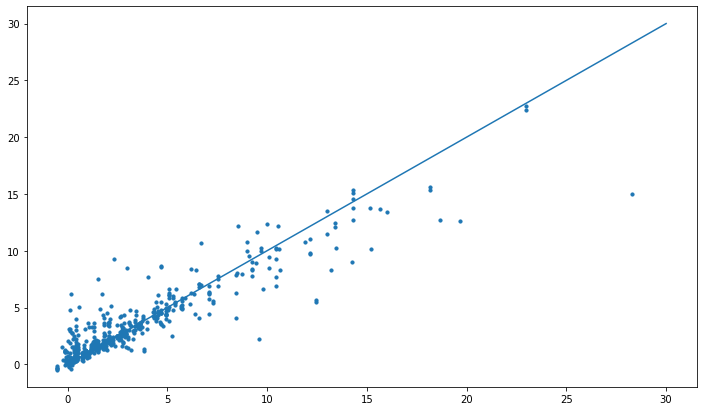

In [1134]:
y_pred = cv.best_estimator_.predict(X_test)
plt.scatter(y_test, y_pred, s=10);
xx = [0, 30]
plt.plot(xx, xx)
mean_absolute_error(y_pred, y_test)

Real:  4.5300523736
Predicted:  4.5275865


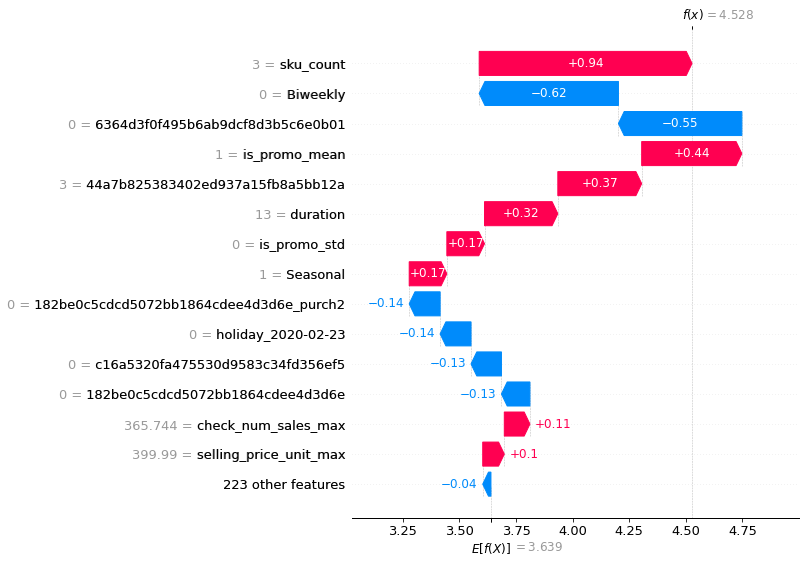

In [1164]:
import shap

idx = 101


explainer = shap.Explainer(cv.best_estimator_)
shap_values = explainer(X_test.reset_index(drop=True))

print('Real: ', y_test.to_list()[idx])
print('Predicted: ', cv.best_estimator_.predict(X_test.reset_index(drop=True))[idx])
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[idx],max_display=15)

In [ ]:
# лучший скор был когда была hi по чекам и не было hi по промо

In [888]:
sorted_idx = np.argsort(cv.best_estimator_.feature_importances_)[::-1]
#for index in sorted_idx:
#    print([X_train.columns[index], cv.best_estimator_.feature_importances_[index]]) 
    
best_features = [X_train.columns[idx] for idx in sorted_idx]

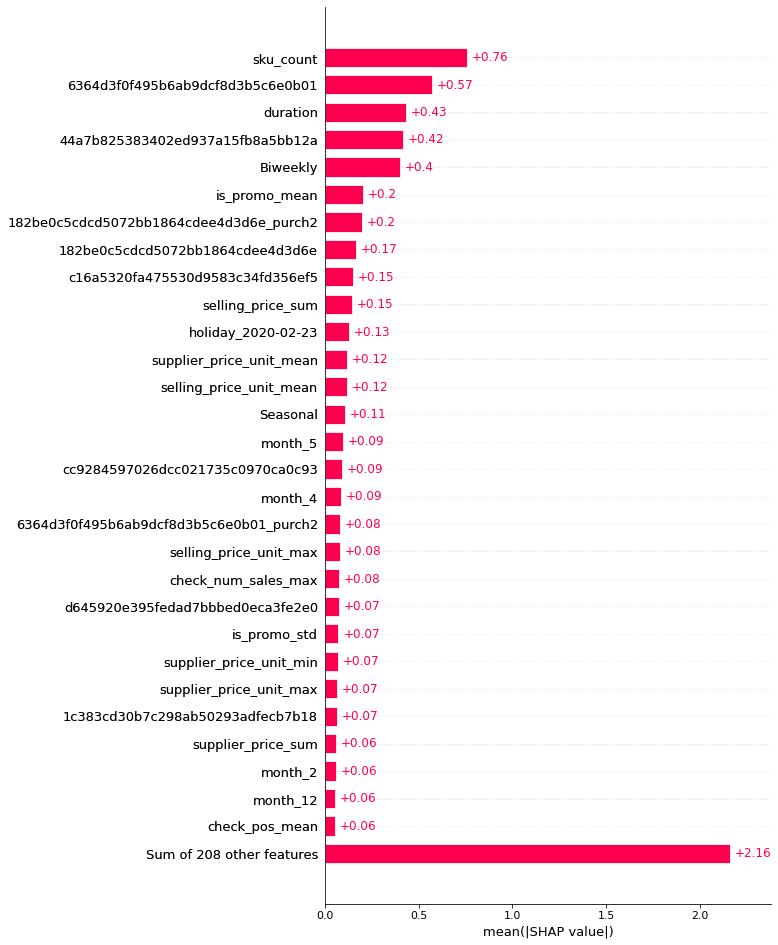

In [1165]:
shap.plots.bar(shap_values, 30)

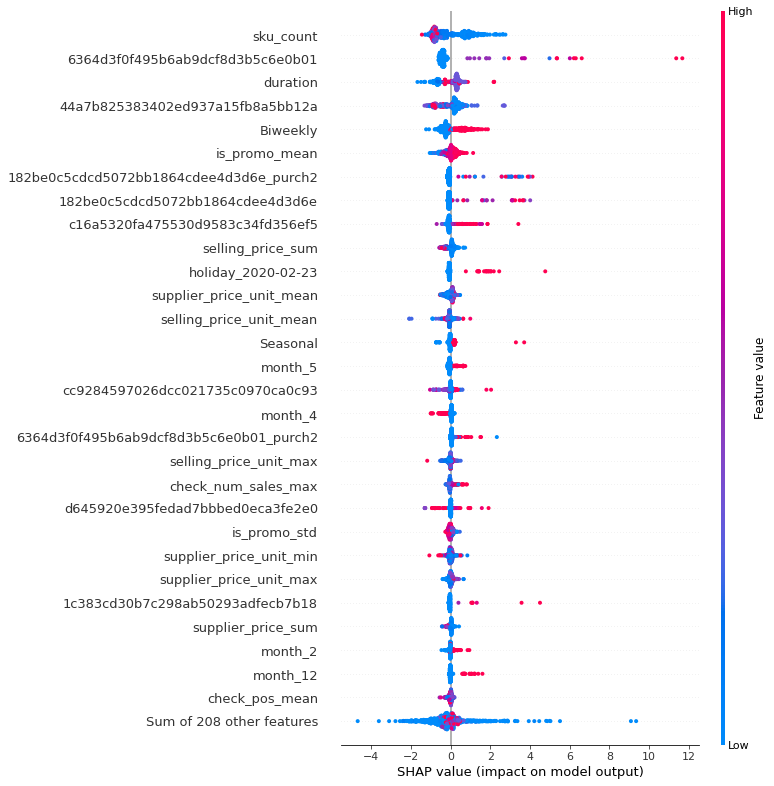

In [1166]:
shap.plots.beeswarm(shap_values, 30)

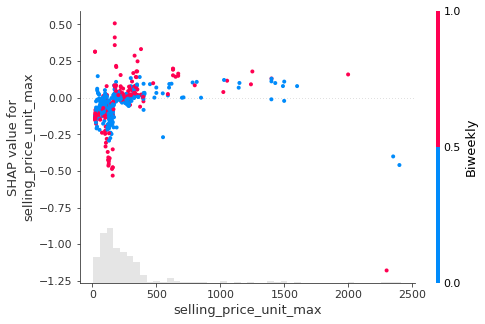

In [1167]:
shap.plots.scatter(shap_values[:,"selling_price_unit_max"], color=shap_values)

In [1135]:
X = data.drop(columns={'UpLift'})
y = data.UpLift
cv.best_estimator_.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=6,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=1400, n_jobs=48, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [1136]:
data_test.shape, data.shape

((2014, 237), (5556, 238))

In [1137]:
data_test = prepare_dataset(df_test, test=True)
data_test = data_test[[col for col in data.columns if col != 'UpLift']]

uplift_pred = cv.best_estimator_.predict(data_test)

In [1138]:
df_test['UpLift'] = uplift_pred


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1139]:
data_test.shape, df_test.shape

((2014, 237), (2014, 414))

In [1158]:
submit = df_test[['Offer_ID', 'UpLift']].groupby('Offer_ID').median().reset_index()
submit.shape

(148, 2)

In [1159]:
df_of[df_of.train_test_group == 'test'].Offer_ID.nunique()

149

In [1160]:
set(df_of[df_of.train_test_group == 'test'].Offer_ID) - set(submit.Offer_ID)

{'F216'}

In [1161]:
submit.at[148, 'Offer_ID'] = 'F216'
submit.at[148, 'UpLift'] = 3

In [1162]:
df_sub = df_sa.copy()

for idx, row in df_sub.iterrows():
    df_sub.at[idx, 'UpLift'] = submit[submit.Offer_ID == row.Offer_ID].UpLift.iloc[0]

In [1163]:
df_sub.to_csv('submit15.csv')